# SLTimer Example Analysis of TDC2 Data

This notebook shows you how to find the estimation of a lens time delay from TDC2 light curve data using the `PyCS` code. For a detailed tutorial through the `PyCS` code, please visit this [address.](https://github.com/DarkEnergyScienceCollaboration/SLTimer/blob/master/notebooks/PyCS_Tutorial.ipynb)

First, we'll import `SLTimer`, as well as a few other important commands. 

In [1]:
from __future__ import print_function
import os, urllib, numpy as np
%matplotlib inline

import sys
sys.path.append('../python')
import desc.sltimer

%load_ext autoreload
%autoreload 2

## Data Munging

Now, let's start a timer object, and download some data to use. The output should show 1006 imported points if we are using the correct `tdc2-gateway-1.txt` file.

In [2]:
timer = desc.sltimer.SLTimer()

In [3]:
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt"
timer.download(url, and_read=True, format='tdc2')

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/A] with 1006 points imported (0 of them masked).
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/B] with 1006 points imported (0 of them masked).


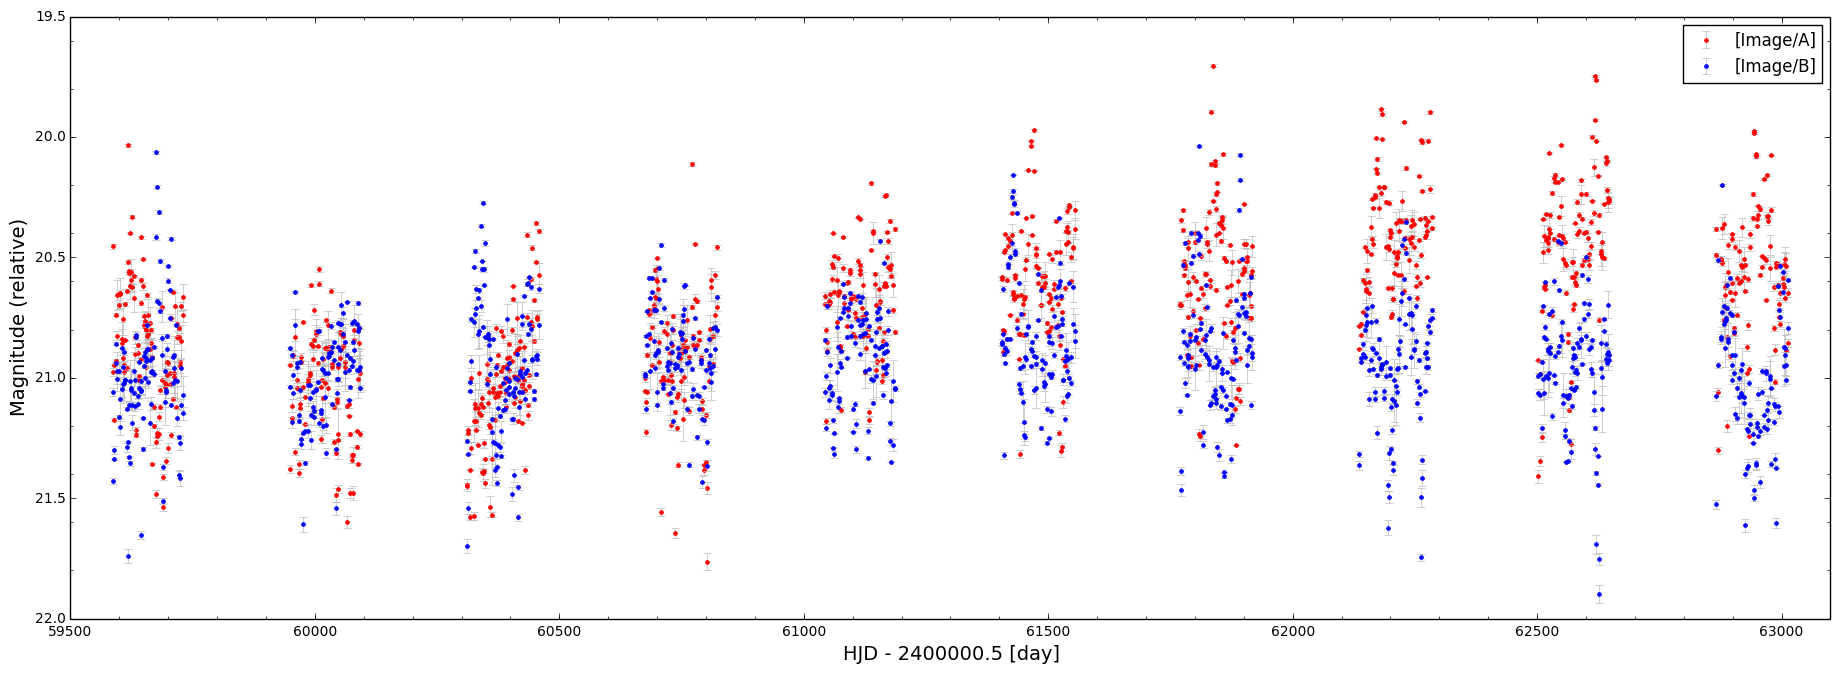

In [4]:
timer.display_light_curves(jdrange=(59500,63100))

## Initialization

The TDC2 light curve data files have headers that contain some lens model information: the Fermat potential differences between the image pairs. These are related to the time delays, by a cosmological distance factor $Q$ and the Hubble constant $H_0$. A broad Gaussian prior on $H_0$ will translate to an approximately Gaussian prior on the time delays. Let's draw from this prior to help initialize the time delays in our model.

In [5]:
# Time delays all set to zero:
# timer.initialize_time_delays(method=None)

# Draw time delays from the prior, using knowledge of H0 and the lens model:
# timer.initialize_time_delays(method='H0_prior', pars=[70.0, 7.0])

# "Guess" the time delays - for testing, let's try something close to the true value:
timer.initialize_time_delays(method='guess', pars={'AB':55.0})

Initialization completed, using method 'guess'
Time Delays:
AB  +55.00


## Spline Modeling

We're now ready to analyze this data. We'll start with it as-is, and then later try "whitening" it.

The following lines will run an entire free-knot spline technique on your data with a complete error analysis using the `TDC2` method. Below, you can specify how the time delays will be analyzed. The default is listed below according to the `PyCS` tutorial. See the bottom of the page for alternate methods. 

In [6]:
timer.estimate_time_delays(method='pycs', microlensing='spline', agn='spline', error=None, quietly=True)
timer.report_time_delays()

You are using the pycs method.
Starting opt_rough on initial delays :
AB  +55.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/21~|
Working on the spline ML of [Image/B](55.000,-0.258,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB  +55.00    (Iteration  1, r2 = 18676307.7)
AB  +55.00    (Iteration  2, r2 = 18267928.9)
AB  +55.00    (Iteration  3, r2 = 18089829.4)
AB  +55.00    (Iteration  4, r2 = 17937801.6)
AB  +55.00    (Iteration  5, r2 = 17804883.2)
Rough time shifts done :
AB  +55.00
Starting opt_rough on initial delays :
AB  +55.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A](2.000,0.000,0)|~3/u/21~|
Working on the spline ML of [Image/B](57.000,-0.258,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB  +57.00    (Iteration  1, r2 = 20598017.2)
AB  +59.00    (Iteration  2, r2 = 18605985.0)
AB  +60.00    (Iteration  3, r2 = 17463659.2)
AB  +61.00    (Iteration  4, r2 = 16601208.2)


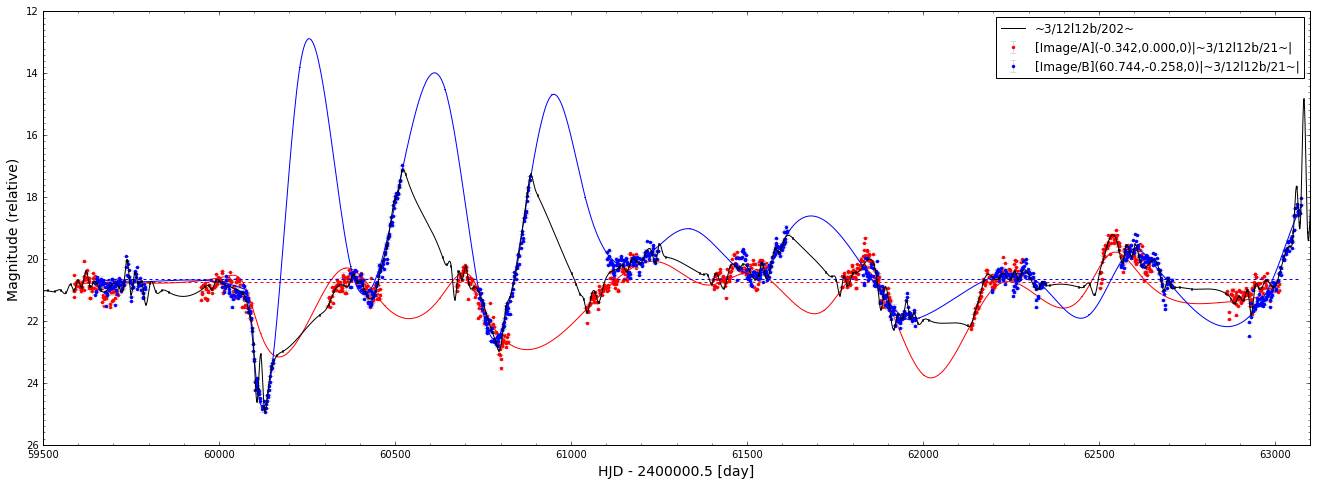

In [7]:
timer.display_light_curves(jdrange=(59500,63100))

While the time delays have been estimated, we can see that the different images' light curves are not shifted and microlensing-corrected terribly well. 

In [8]:
# timer.estimate_uncertainties(n=3,npkl=5)

## Whitening the Light Curves

In the above analysis we ignored the fact that the magnitudes were measured in 6 different filters, and just used them all as if they were from the same filter. By offsetting the light curves to a common mean, we should get a set of points that look more like they were taken in one filter. This process is known as "whitening."

In [8]:
wtimer = desc.sltimer.SLTimer()
wtimer.download(url, and_read=True, format='tdc2')

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/A] with 1006 points imported (0 of them masked).
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/B] with 1006 points imported (0 of them masked).


In [9]:
wtimer.whiten()

whiten: before whitening, means = {'A': 20.709889147670172, 'B': 20.942986859620213}
whiten: before whitening, scatters = {'A': 0.33118712223926866, 'B': 0.24520912405242917}
whiten: detected bands: ['g' 'i' 'r' 'u' 'y' 'z']
whiten: after whitening, means = {'A': 20.709889147670172, 'B': 20.942986859620213}
whiten: after whitening, scatters = {'A': 0.32647791567919016, 'B': 0.24278378000885809}


The change brought about by whitening is pretty subtle: the means of each image's light curve stay the same (by design), but the scatter in each image's light curve is somewhat reduced. 

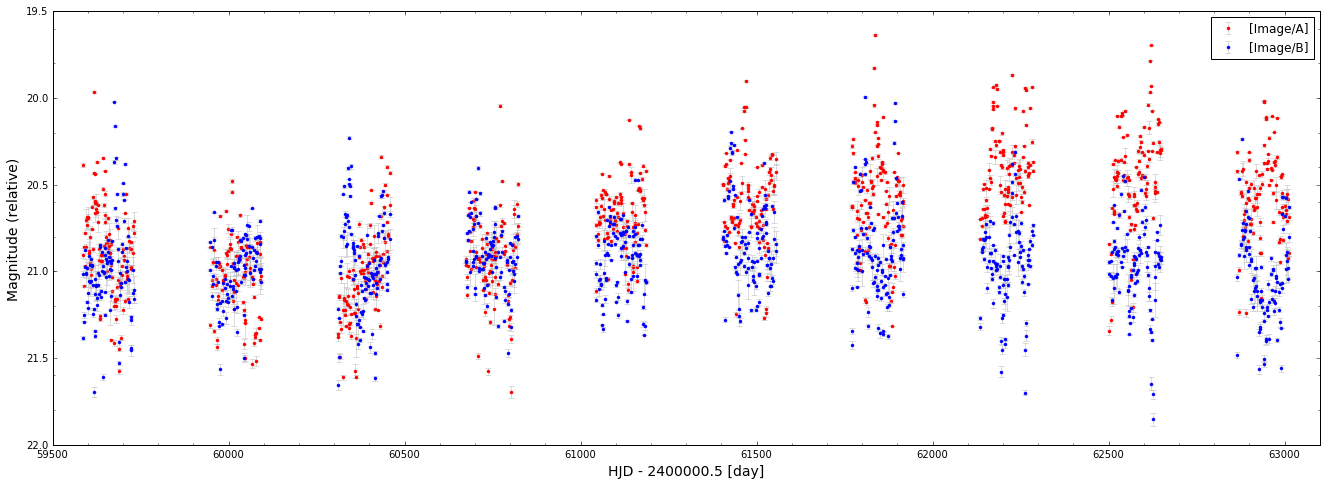

In [10]:
wtimer.display_light_curves(jdrange=(59500,63100))

In [11]:
wtimer.initialize_time_delays(method='guess', pars={'AB':55.0})
wtimer.estimate_time_delays(method='pycs', microlensing='spline', agn='spline', error=None, quietly=True)

Initialization completed, using method 'guess'
Time Delays:
AB  +55.00


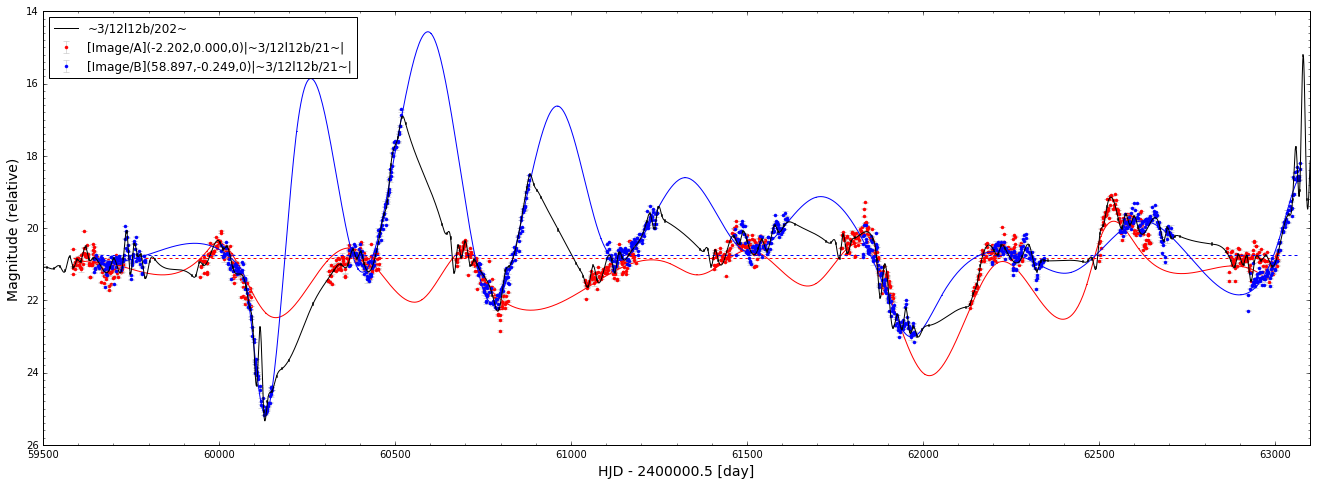

In [12]:
wtimer.display_light_curves(jdrange=(59500,63100))

How does the plot compare? Note that the y axis scale is different: the shifted light curves seem to match up better now.

Now let's look at the estimated time delays - by how much do they differ, between the unwhitened and whitened data?

#### Whitened:

In [13]:
wtimer.report_time_delays()

Time Delays:
AB  +61.10


#### Unwhitened:

In [14]:
timer.report_time_delays()

Time Delays:
AB  +61.09


#### Truth:

In [15]:
truthurl = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/gatewaytruth.txt"
truthfile = truthurl.split('/')[-1]
if not os.path.isfile(truthfile):
    urllib.urlretrieve(truthurl, truthfile)
d = np.loadtxt(truthfile).transpose()
truth = d[0]
print("True Time Delays:", truth[0])

True Time Delays: 55.37


## Conclusions

The above demo shows that:

* We can read in and analyze multi-filter TDC2 data with `PyCS`
* Whitening the data may lead to improved estimates, but more tests will be needed - the current implementation does not make a big difference to the time delay estimation results.
* It's easy to get stuck at a local maximum in the time delay likelihood function.

We are currently experimenting with initializing the fit to avoid getting stuck at local maxima, by choosing time delays based on our prior knowledge of a) the lens model and b) the Hubble constant.